In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hridoyyahmed","key":"a5cfecb17b0b1597d9565221455fc0ac"}'}

In [2]:

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!mkdir -p /content/ravdess

! kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio

!unzip ravdess-emotional-speech-audio.zip -d /content/ravdess


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
Archive:  ravdess-emotional-speech-audio.zip
  inflating: /content/ravdess/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: /content/ravdess/Actor_01/03-01-03

In [119]:
from glob import glob
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Concatenate, Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report




In [4]:
raw_audio = glob('/content/ravdess/Actor_*/*.wav')

In [5]:
print(f'Total Audio Sample {len(raw_audio)}')

Total Audio Sample 1440


In [34]:
# Initialize empty lists
y_list = []
sr_list = []
gender_list = []
emotion_list = []
statement_list = []
intensity_list = []

# Loop through each audio file
for audio in raw_audio:
    # Load the audio file
    y, sr = librosa.load(audio)
    y_trimmed, interval = librosa.effects.trim(y, top_db=40)  # top_db is the threshold in decibels
    # Extract metadata from the filename
    # Example filename: /path/to/03-01-05-02-01-01-24.wav
    data = audio.split('/')[-1].split('.')[0].split('-')  # Get filename and split by '-'

    # Extract fields
    emotion = data[2]  # Emotion code
    intensity = data[3]  # Intensity code
    statement = data[4]  # Statement code
    gender = int(data[6])  # Actor ID (used to determine gender)

    # Convert emotion code to label
    if emotion == '01':
        emotion = 'neutral'
    elif emotion == '02':
        emotion = 'calm'
    elif emotion == '03':
        emotion = 'happy'
    elif emotion == '04':
        emotion = 'sad'
    elif emotion == '05':
        emotion = 'angry'
    elif emotion == '06':
        emotion = 'fearful'
    elif emotion == '07':
        emotion = 'disgust'
    elif emotion == '08':
        emotion = 'surprised'

    # Convert intensity code to label
    if intensity == '01':
        intensity = 'normal'
    elif intensity == '02':
        intensity = 'strong'

    # Convert statement code to text
    if statement == '01':
        statement = 'Kids are talking by the door'
    elif statement == '02':
        statement = 'Dogs are sitting by the door'

    # Convert actor ID to gender
    if gender % 2 == 0:
        gender = 'female'
    else:
        gender = 'male'

    # Append to respective lists
    y_list.append(y_trimmed)  # Append the NumPy array for the audio
    sr_list.append(sr)  # Append the sample rate
    gender_list.append(gender)  # Append the gender label
    emotion_list.append(emotion)  # Append the emotion label
    statement_list.append(statement)  # Append the statement text
    intensity_list.append(intensity)  # Append the intensity label

In [36]:
unique_sr = np.unique(sr_list)
unique_sr

array([22050])

In [37]:
# Create a DataFrame
df = pd.DataFrame({
    'audio': y_list,
    'sample_rate': sr_list,
    'gender': gender_list,
    'emotion': emotion_list,
    'statement': statement_list,
    'intensity': intensity_list
})

In [38]:
df

,audio,sample_rate,gender,emotion,statement,intensity
0,"[2.0612175e-05, 2.0491689e-07, 1.0211021e-05, ...",22050,female,angry,Kids are talking by the door,normal
1,"[1.5437818e-06, -1.2670389e-06, 1.0206384e-06,...",22050,female,disgust,Dogs are sitting by the door,normal
2,"[7.645002e-05, 0.00012893946, 9.671217e-05, 4....",22050,female,disgust,Kids are talking by the door,strong
3,"[5.2001604e-05, 0.00079869555, -0.0007061236, ...",22050,female,fearful,Kids are talking by the door,strong
4,"[2.984977e-06, -1.072464e-05, -7.0054643e-06, ...",22050,female,sad,Dogs are sitting by the door,normal
...,...,...,...,...,...,...
1435,"[0.00013447746, 0.00013277339, 0.00012904499, ...",22050,female,sad,Kids are talking by the door,normal
1436,"[-3.3702656e-07, 2.489844e-07, -1.4221273e-07,...",22050,female,neutral,Dogs are sitting by the door,normal
1437,"[0.0024038313, -0.0011077891, -0.0004386246, -...",22050,female,sad,Dogs are sitting by the door,strong
1438,"[-2.2475099e-07, 2.555903e-07, -2.8387777e-07,...",22050,female,angry,Kids are talking by the door,normal


In [39]:
df[['audio','sample_rate','gender', 'emotion', 'statement', 'intensity']].to_csv('/content/ravdess_metadata.csv', index=False)

# Download the file to your local device
files.download('/content/ravdess_metadata.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

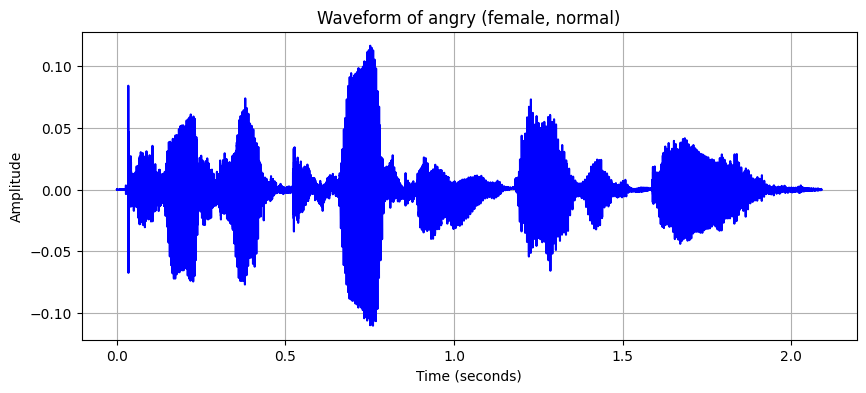

In [44]:
# Assuming df is your DataFrame with 'audio' and 'sample_rate' columns
# Or use y_list and sr_list directly
index = 0  # Choose the index of the audio file to plot
y = df['audio'].iloc[index]  # or y_list[index]
sr = df['sample_rate'].iloc[index]  # or sr_list[index]

# Create time axis
time = np.arange(0, len(y)) / sr  # Time in seconds

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(time, y, color='b')
plt.title(f"Waveform of {df['emotion'].iloc[index]} ({df['gender'].iloc[index]}, {df['intensity'].iloc[index]})")
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [51]:

# 1. Nominal Encoding for 'gender' and 'emotion'
le_gender = LabelEncoder()
le_emotion = LabelEncoder()

df['gender_encoded'] = le_gender.fit_transform(df['gender'])
df['emotion_encoded'] = le_emotion.fit_transform(df['emotion'])

# 2. Ordinal Encoding for 'intensity'
intensity_order = CategoricalDtype(categories=['normal', 'strong'], ordered=True)
df['intensity_encoded'] = df['intensity'].astype(intensity_order).cat.codes

# View the updated DataFrame
print(df[['gender', 'gender_encoded', 'emotion', 'emotion_encoded', 'intensity', 'intensity_encoded']].head())


   gender  gender_encoded  emotion  emotion_encoded intensity  \
0  female               0    angry                0    normal   
1  female               0  disgust                2    normal   
2  female               0  disgust                2    strong   
3  female               0  fearful                3    strong   
4  female               0      sad                6    normal   

   intensity_encoded  
0                  0  
1                  0  
2                  1  
3                  1  
4                  0  


In [53]:
df.drop(['gender', 'emotion','sample_rate','intensity'], axis=1, inplace=True)

In [55]:
le_statement = LabelEncoder()

df['statement_encoded'] = le_statement.fit_transform(df['statement'])

In [57]:
df.drop(['statement'], axis=1, inplace=True)

In [59]:

def z_score_normalize(audio_array):
    audio_array = np.array(audio_array)
    mean = np.mean(audio_array)
    std = np.std(audio_array)
    # Avoid division by zero
    if std == 0:
        return audio_array - mean
    return (audio_array - mean) / std

# Apply normalization to each audio row
df['normalized_audio'] = df['audio'].apply(z_score_normalize)

# Create new_df with normalized audio and encoded labels
new_df = df[['normalized_audio', 'gender_encoded', 'emotion_encoded', 'intensity_encoded', 'statement_encoded']].copy()

# Optional: Rename 'normalized_audio' to 'audio' for consistency
new_df.rename(columns={'normalized_audio': 'audio'}, inplace=True)

In [60]:
new_df

,audio,gender_encoded,emotion_encoded,intensity_encoded,statement_encoded
0,"[0.0040165246, 0.0027116314, 0.0033514479, -0....",0,0,0,1
1,"[0.00044813083, 0.00013860855, 0.00039052326, ...",0,2,0,0
2,"[0.0024275095, 0.004683833, 0.0032985029, 0.00...",0,2,1,1
3,"[0.00021281614, 0.011858158, -0.011610806, -0....",0,3,1,1
4,"[0.000654531, -0.0011865572, -0.00068710267, 0...",0,6,0,0
...,...,...,...,...,...
1435,"[0.012584834, 0.012426389, 0.012079722, 0.0093...",0,6,0,1
1436,"[0.0007500898, 0.0008918998, 0.0007972332, 0.0...",0,5,0,0
1437,"[0.07263646, -0.03347731, -0.01325657, -0.0499...",0,6,1,0
1438,"[-5.9447107e-06, 1.7023367e-05, -8.771927e-06,...",0,0,0,1


In [61]:
def extract_mfcc(audio_array, sr=22050, n_mfcc=13):
    # Convert list to np array in case it's not already
    audio_array = np.array(audio_array)
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=n_mfcc)
    # Take the mean of each MFCC across time (to get fixed-length feature vector)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

In [62]:
# Assuming new_df['audio'] is normalized
X = new_df['audio'].apply(lambda x: extract_mfcc(x))
X = np.stack(X.to_numpy())  # Convert to 2D array
y = new_df['emotion_encoded'].to_numpy()


In [69]:
new_df['audio'][0].shape

(46080,)

In [63]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.61      0.71        49
           1       0.48      0.71      0.57        35
           2       0.46      0.50      0.48        34
           3       0.50      0.51      0.51        35
           4       0.58      0.58      0.58        36
           5       0.40      0.33      0.36        18
           6       0.44      0.49      0.46        39
           7       0.61      0.48      0.53        42

    accuracy                           0.54       288
   macro avg       0.54      0.53      0.53       288
weighted avg       0.56      0.54      0.54       288



In [98]:
new_df

,audio,gender_encoded,emotion_encoded,intensity_encoded,statement_encoded
0,"[0.0040165246, 0.0027116314, 0.0033514479, -0....",0,0,0,1
1,"[0.00044813083, 0.00013860855, 0.00039052326, ...",0,2,0,0
2,"[0.0024275095, 0.004683833, 0.0032985029, 0.00...",0,2,1,1
3,"[0.00021281614, 0.011858158, -0.011610806, -0....",0,3,1,1
4,"[0.000654531, -0.0011865572, -0.00068710267, 0...",0,6,0,0
...,...,...,...,...,...
1435,"[0.012584834, 0.012426389, 0.012079722, 0.0093...",0,6,0,1
1436,"[0.0007500898, 0.0008918998, 0.0007972332, 0.0...",0,5,0,0
1437,"[0.07263646, -0.03347731, -0.01325657, -0.0499...",0,6,1,0
1438,"[-5.9447107e-06, 1.7023367e-05, -8.771927e-06,...",0,0,0,1


In [102]:
# Modified MFCC extraction function for LSTM
def extract_mfcc(audio_array, sr=22050, n_mfcc=13, max_length=100):
    """Extract MFCCs and pad/truncate to fixed length for LSTM."""
    audio_array = np.array(audio_array)
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=n_mfcc)  # Shape: (n_mfcc, time_steps)
    # Pad or truncate to max_length
    if mfccs.shape[1] > max_length:
        mfccs = mfccs[:, :max_length]
    else:
        mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
    return mfccs.T  # Shape: (max_length, n_mfcc)

In [105]:
# Step 1: Extract MFCCs
max_length = 100  # Adjust based on your audio lengths (e.g., inspect max time steps)
X_mfcc = np.array([extract_mfcc(y, sr=22050, n_mfcc=13, max_length=max_length) for y in new_df['audio']])

In [107]:
# Prepare target variable
n_classes = len(df['emotion_encoded'].unique())  # Should be 8 for RAVDESS
y = to_categorical(df['emotion_encoded'], num_classes=n_classes)

In [108]:
# Step 2: Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X_mfcc, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [110]:
# Step 3: Build LSTM Model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [111]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100, 128)       │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,456 (486.16 KB)

 Trainable params: 124,456 (486.16 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
# Step 4: Train Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.1556 - loss: 2.0528 - val_accuracy: 0.2963 - val_loss: 1.9260
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3262 - loss: 1.8528 - val_accuracy: 0.3194 - val_loss: 1.8075
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3919 - loss: 1.6762 - val_accuracy: 0.3657 - val_loss: 1.6068
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4428 - loss: 1.4775 - val_accuracy: 0.4259 - val_loss: 1.5092
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5362 - loss: 1.2548 - val_accuracy: 0.4167 - val_loss: 1.4325
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5855 - loss: 1.1954 - val_accuracy: 0.4954 - val_loss: 1.3952
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6324 - loss: 1.0428 - val_accuracy: 0.5000 - val_loss: 1.3970
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6357 - loss: 1.0164 - val_accuracy: 0.4769 - v

In [113]:
# Step 5: Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.6389


In [114]:
# Predictions for confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [122]:
emotion_labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

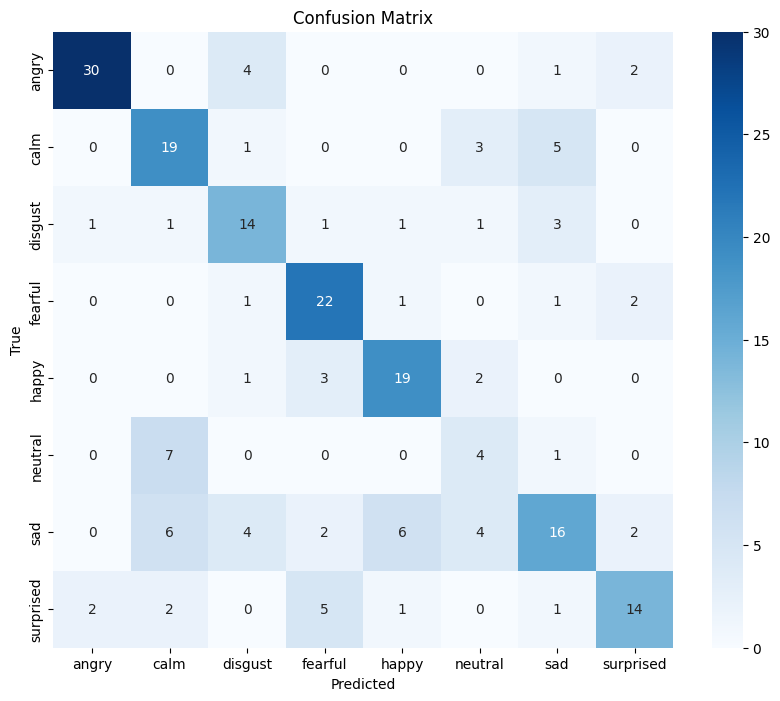

In [120]:
# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Classification Report:
              precision    recall  f1-score   support

       angry       0.91      0.81      0.86        37
        calm       0.54      0.68      0.60        28
     disgust       0.56      0.64      0.60        22
     fearful       0.67      0.81      0.73        27
       happy       0.68      0.76      0.72        25
     neutral       0.29      0.33      0.31        12
         sad       0.57      0.40      0.47        40
   surprised       0.70      0.56      0.62        25

    accuracy                           0.64       216
   macro avg       0.61      0.62      0.61       216
weighted avg       0.65      0.64      0.64       216



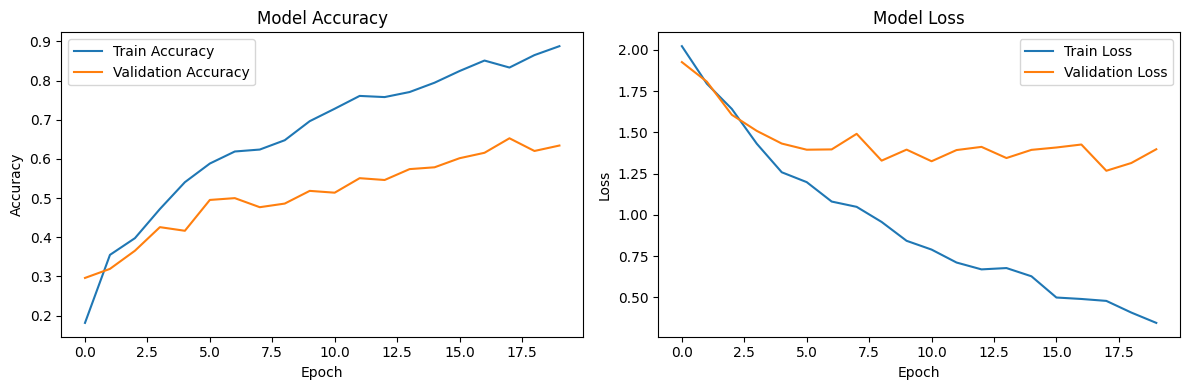

In [121]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=emotion_labels))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

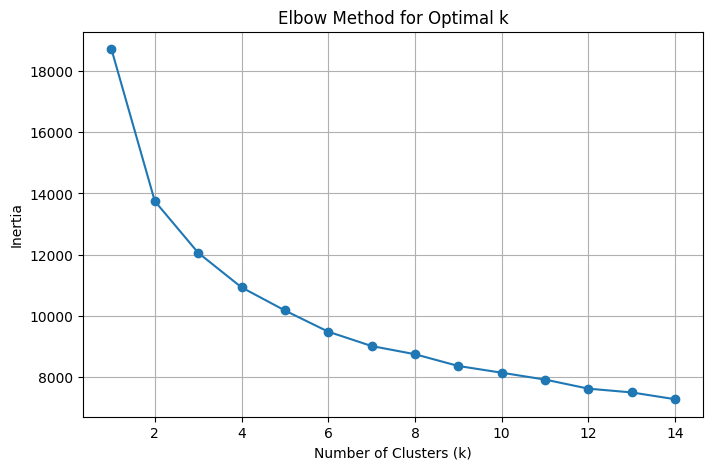


Cross-Tabulation (Cluster vs. Emotion):
emotion_encoded  angry  calm  disgust  fearful  happy  neutral  sad  surprised
cluster                                                                       
0                   10     0        0       24     10        0    6          0
1                   16    32       46       22     15       12   25         24
2                   28    56       29       20     22       14   18         41
3                   44     1       14       24     33        4   14         32
4                   11    53       24       28     10       16   43         17
5                   19    24       29       28     25       18   40         17
6                   41     1       29       33     48        7   18         49
7                   23    25       21       13     29       25   28         12


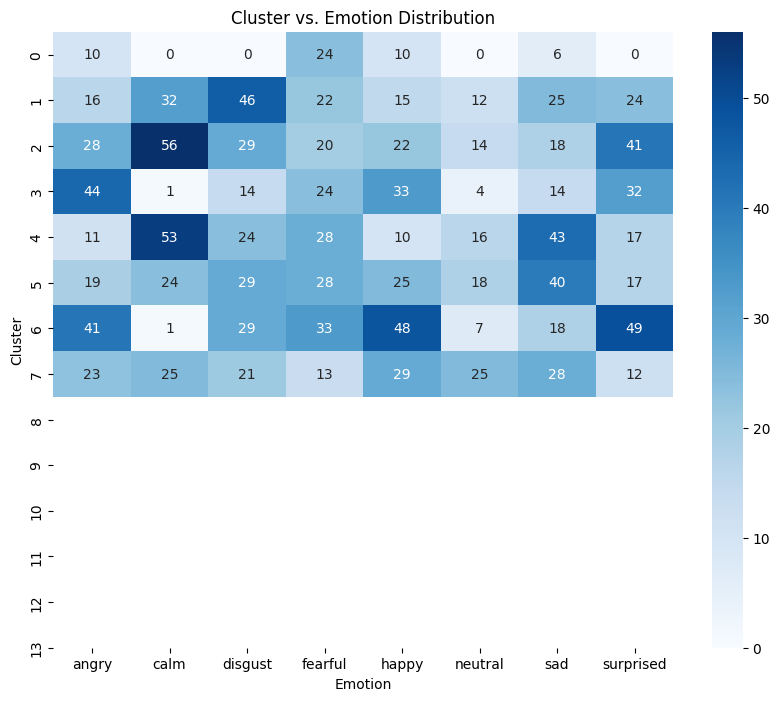

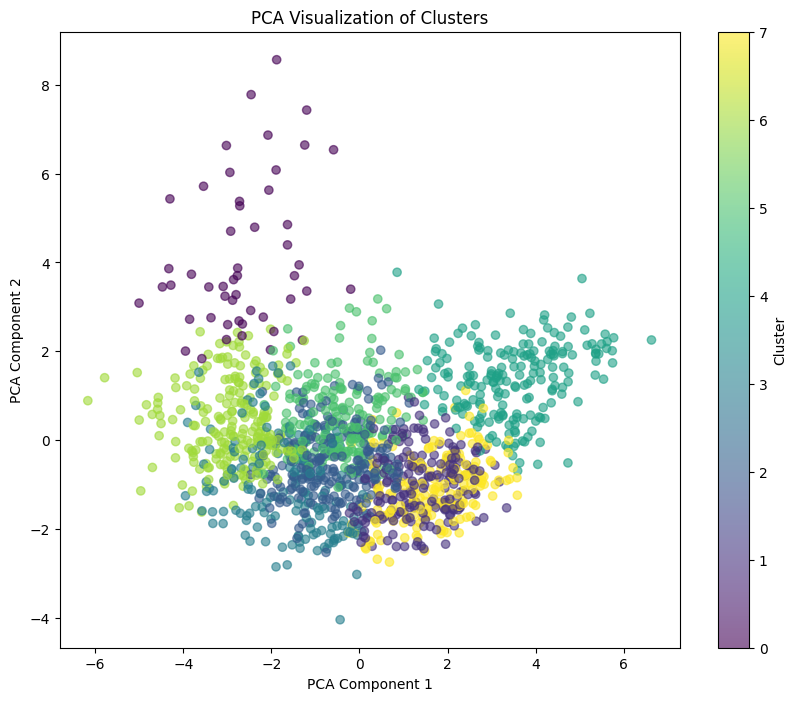

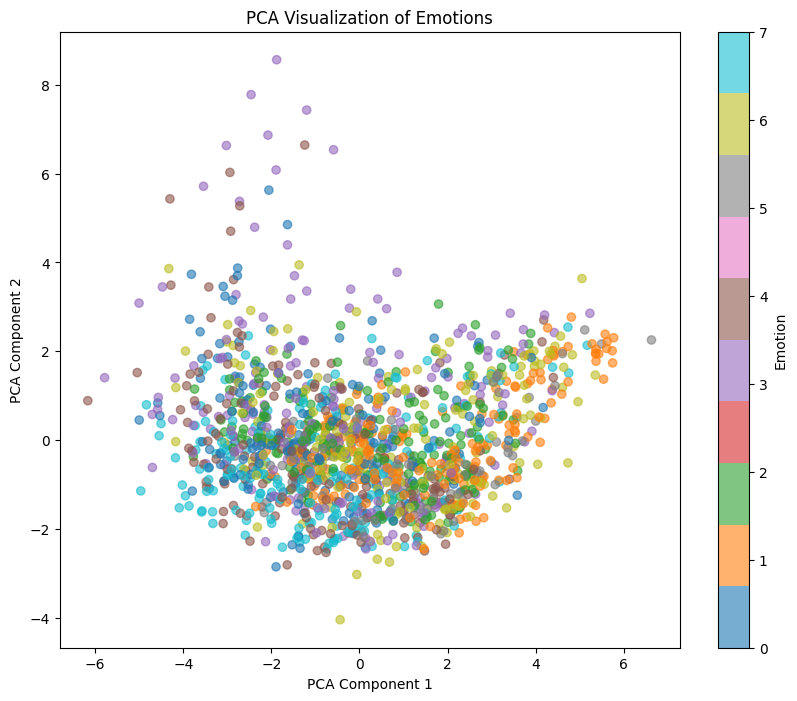

In [124]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Your MFCC extraction function
def extract_mfcc(audio_array, sr=22050, n_mfcc=13):
    audio_array = np.array(audio_array)
    mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)  # Shape: (n_mfcc,)
    return mfccs_mean

# Verify new_df has required columns
required_columns = ['audio', 'emotion_encoded']
if not all(col in new_df.columns for col in required_columns):
    missing = [col for col in required_columns if col not in new_df.columns]
    raise ValueError(f"new_df is missing columns: {missing}")

# Step 1: Extract Mean MFCCs
new_df['mfcc'] = [extract_mfcc(y, sr=22050, n_mfcc=13) for y in new_df['audio']]

# Step 2: Prepare Features
# Use MFCCs and optionally include encoded metadata
features = np.array(new_df['mfcc'].tolist())  # Shape: (n_samples, n_mfcc)


# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Apply K-Means Clustering
# Choose number of clusters (e.g., 8 for emotions)
k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
new_df['cluster'] = kmeans.fit_predict(features_scaled)

# Elbow method to explore optimal k
inertia = []
k_range = range(1, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Step 4: Analyze Results
# Compare clusters to emotions
emotion_labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
cross_tab = pd.crosstab(new_df['cluster'], new_df['emotion_encoded'].map(dict(enumerate(emotion_labels))))
print("\nCross-Tabulation (Cluster vs. Emotion):")
print(cross_tab)

# Confusion matrix-like visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=range(k))
plt.title('Cluster vs. Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Cluster')
plt.show()

# Visualize clusters using PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=new_df['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('PCA Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Compare with emotions for reference
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=new_df['emotion_encoded'], cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Emotion', ticks=range(len(emotion_labels)))
plt.title('PCA Visualization of Emotions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

